#Module 7 Project: Movie Recommendation Engine

In this module, we will try to create a Movie Recommendation System using different unsupervised learning techniques.

In [1]:
# dataset download

# !wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2025-04-22 03:46:14--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  2.43MB/s    in 0.4s    

2025-04-22 03:46:15 (2.43 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


## Clustering based recommendation

In [2]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
# Import the Movies dataset
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Import the ratings dataset
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# Print the number of records and the total number of movies
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100836  ratings of  9742  movies.


### Romance versus Science Fiction

We will start by considering a subset of users and discovering what are their favourite genre. We will do this by defining a function that will calculate each user’s average rating for all science fiction and romance movies.

In [6]:
# Function to get the genre ratings
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)

        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)

    genre_ratings.columns = column_names
    return genre_ratings# Calculate the average rating of romance and scifi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
1,4.31,4.22
2,4.50,3.88
3,0.50,4.20
4,3.38,2.83
5,3.09,2.50


In order to have a more delimited subset of people to study, we are going to bias our grouping to only get ratings from those users that like either romance or science fiction movies.

In [7]:
# Function to get the biased dataset
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

# Bias the dataset
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  162


,index,avg_romance_rating,avg_scifi_rating
0,3,0.50,4.20
1,4,3.38,2.83
2,5,3.09,2.50
3,7,2.65,3.15
4,9,3.17,3.00


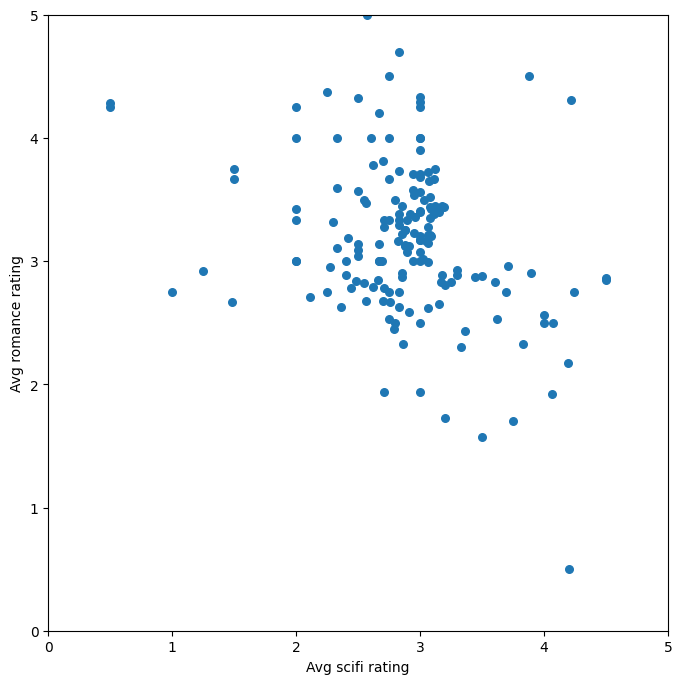

In [8]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)

# Plot the scatterplot
draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

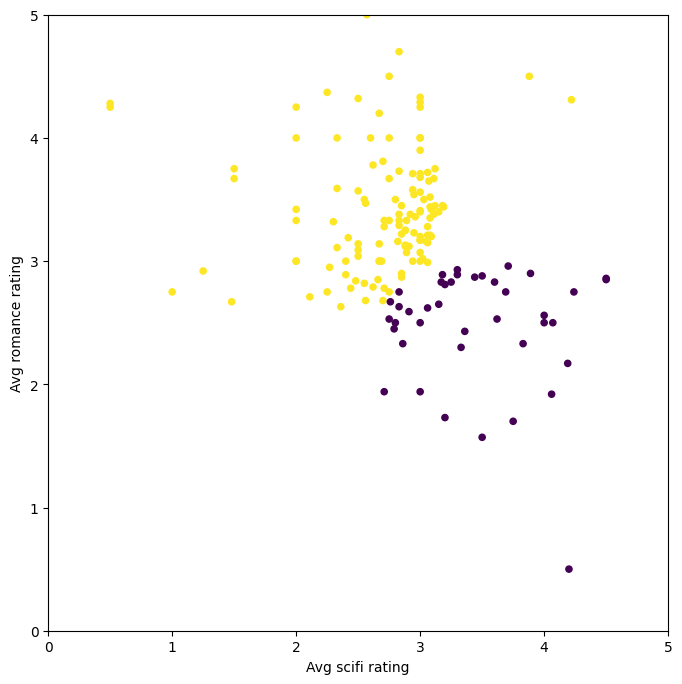

In [9]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values

# Import KMeans
from sklearn.cluster import KMeans

# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)

# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)

# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)

# Plot
draw_clusters(biased_dataset, predictions)

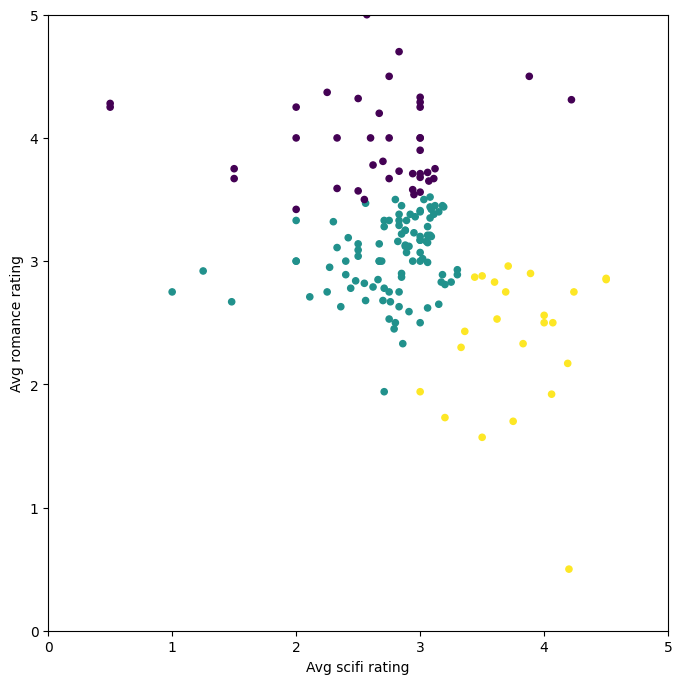

In [10]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)
# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_2)

It is evident now that the science-fiction rating has started to come into play:

    People who like sci-fi and romance modeately belong to the green group.
    People who like scifi but not romance belong to the yello group.
    People who like romance but not sci-fi belong to the purple group.

Finding optimal clusters using silhouette score

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (157) found smaller than n_clusters (162). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


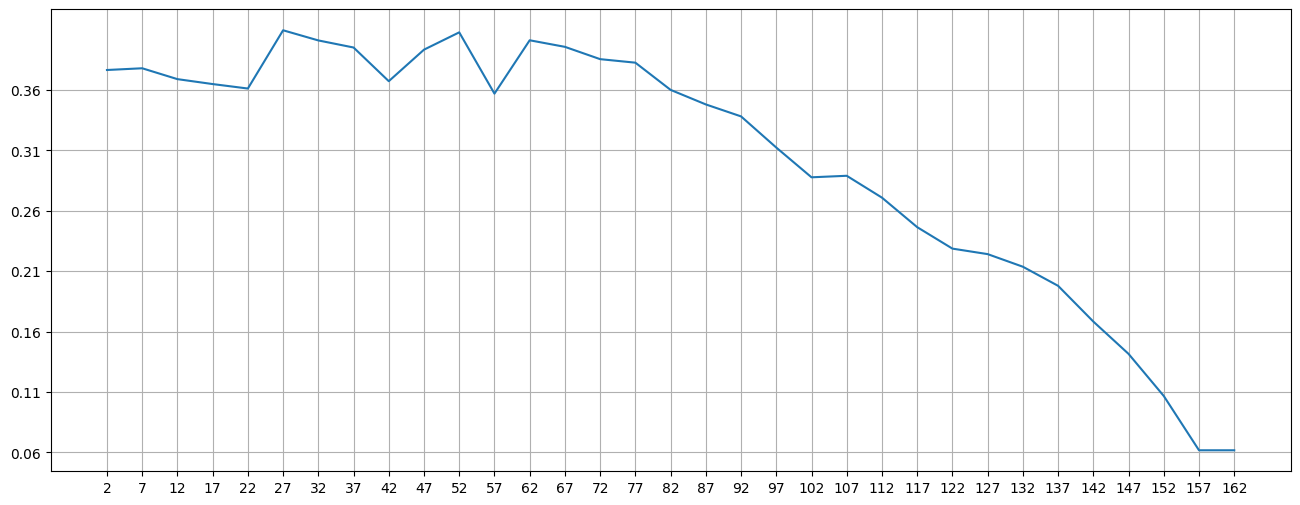

In [11]:
# Selecting our dataset to study
df = biased_dataset[['avg_scifi_rating','avg_romance_rating']]

# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5)

# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]

# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

We will chose the K = 7 as it is the one that yields the best score and will be easier to visualize.



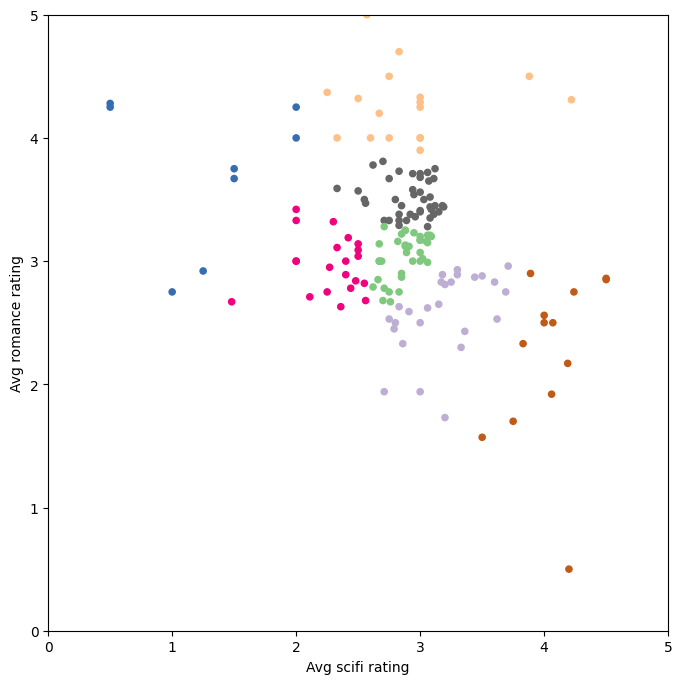

In [12]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

Up to now, we have only analyzed romance and science-fiction movies. Let us see what happens when adding other genre to our analysis by adding Action movies.

In [13]:
# Select our biased dataset and add action genre
biased_dataset_3_genres = get_genre_ratings(ratings, movies, ['Romance','Sci-Fi', 'Action'],
['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating'])
# Drop null values
biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()
# Print the number of records and the head of our dataset
print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Number of records:  161


,index,avg_romance_rating,avg_scifi_rating,avg_action_rating
0,3,0.50,4.20,3.57
1,4,3.38,2.83,3.32
2,5,3.09,2.50,3.11
3,7,2.65,3.15,3.26
4,9,3.17,3.00,3.12


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


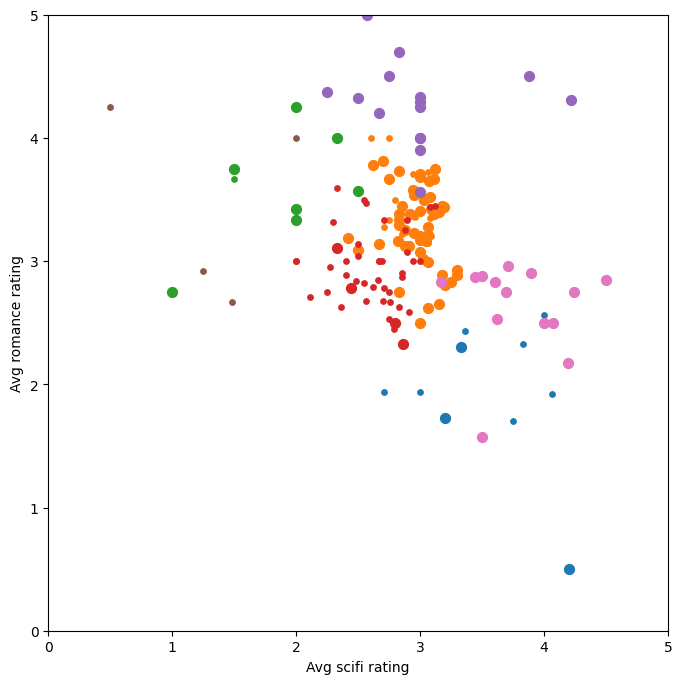

In [ ]:
# Turn dataset into a list
X_with_action = biased_dataset_3_genres[['avg_scifi_rating','avg_romance_rating','avg_action_rating']].values# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_5 = kmeans_5.fit_predict(X_with_action)
# Define 3d plotting function
def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3:
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_scifi_rating'],
                        point['avg_romance_rating'],
                        s=size,
                        color=color)# Plot
draw_clusters_3d(biased_dataset_3_genres, predictions_5)

The size of the dots represent the ratings of the action movies.

# Exercise 1

## Instead of choosing a n_clusters as 7, play around with different k
## Find the optimal no of clusters with 3 genre_ratings data we just created using silhouette score method

Silhouette score for 2 clusters (3 Genres): 0.2955
Silhouette score for 3 clusters (3 Genres): 0.2827
Silhouette score for 4 clusters (3 Genres): 0.3024
Silhouette score for 5 clusters (3 Genres): 0.2559
Silhouette score for 6 clusters (3 Genres): 0.2692
Silhouette score for 7 clusters (3 Genres): 0.3038
Silhouette score for 8 clusters (3 Genres): 0.2883
Silhouette score for 9 clusters (3 Genres): 0.2681
Silhouette score for 10 clusters (3 Genres): 0.2891


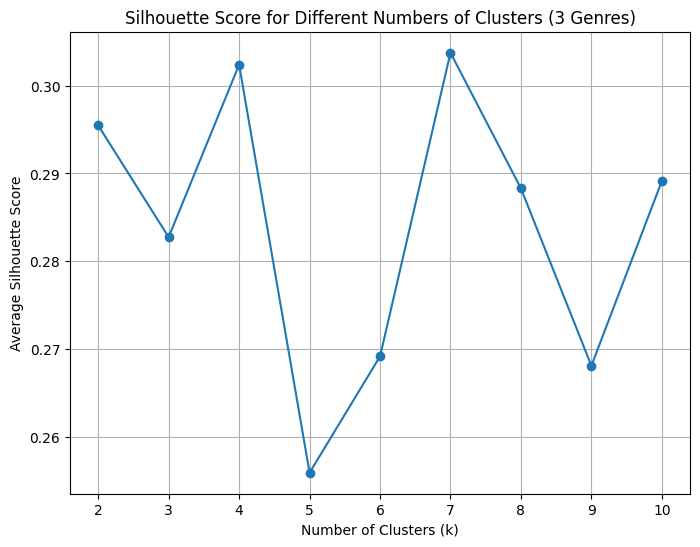


The optimal number of clusters based on silhouette score for 3 genres is: 7


In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have 'biased_dataset_3_genres' DataFrame
X_3d = biased_dataset_3_genres[['avg_scifi_rating', 'avg_romance_rating', 'avg_action_rating']].values

silhouette_scores_3d = []
possible_clusters = range(2, 11)  # Let's try a range from 2 to 10 clusters

for n_clusters in possible_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_3d)
    silhouette_avg = silhouette_score(X_3d, cluster_labels)
    silhouette_scores_3d.append(silhouette_avg)
    print(f"Silhouette score for {n_clusters} clusters (3 Genres): {silhouette_avg:.4f}")

# Plot the silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(possible_clusters, silhouette_scores_3d, marker='o')
plt.title('Silhouette Score for Different Numbers of Clusters (3 Genres)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.xticks(possible_clusters)
plt.grid(True)
plt.show()

# The optimal number of clusters is the one with the highest silhouette score.
# You'll need to examine the output and the plot to determine this value.
optimal_k_3d = possible_clusters[np.argmax(silhouette_scores_3d)]
print(f"\nThe optimal number of clusters based on silhouette score for 3 genres is: {optimal_k_3d}")

# You can then use this optimal_k_3d to perform your final clustering and visualization.

### Taking users into consideration

Once we have seen and understood how the K-Means algorithm group the users by their movie genre preferences, we are going to take a bigger picture of the dataset and explore how users rate individual movies.

To do so, we will subset the dataset by ‘userid’ vs ‘user rating’ as follows.

In [15]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

# Print he number of dimensions and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (610, 9719) 

Subset example:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Define Function to get the most rated movies
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    movie_counts = user_movie_ratings.count().rename('count')
    user_movie_ratings = pd.concat([user_movie_ratings, movie_counts.to_frame().T], ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(user_movie_ratings.index[-1], axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

# Define function to get the user who rate a movie the most
def get_users_who_rate_the_most(most_rated_movies, n_users):
    most_rated_movies['num_ratings'] = - most_rated_movies.isnull().sum(axis=1)
    most_rated_movies = most_rated_movies.sort_values(by=['num_ratings'], ascending=False)
    most_rated_movies = most_rated_movies.iloc[:n_users, :]
    most_rated_movies = most_rated_movies.drop('num_ratings', axis=1)
    return most_rated_movies

# Define the sorting by rating density function
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

# choose the number of movies and users and sort
n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

# Print the result
print('dataset dimensions: ', most_rated_movies_users_selection.shape)
print(most_rated_movies_users_selection.head())

dataset dimensions:  (18, 30)
title  Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
479                    5.0                               5.0   
473                    3.0                               5.0   
413                    5.0                               5.0   
67                     3.5                               3.0   
589                    5.0                               4.5   

title  Pulp Fiction (1994)  Silence of the Lambs, The (1991)  \
479                    4.0                               4.5   
473                    4.0                               4.5   
413                    5.0                               4.0   
67                     2.0                               3.5   
589                    4.5                               3.5   

title  Matrix, The (1999)  Star Wars: Episode IV - A New Hope (1977)  \
479                   5.0                                        4.5   
473                   4.5                               

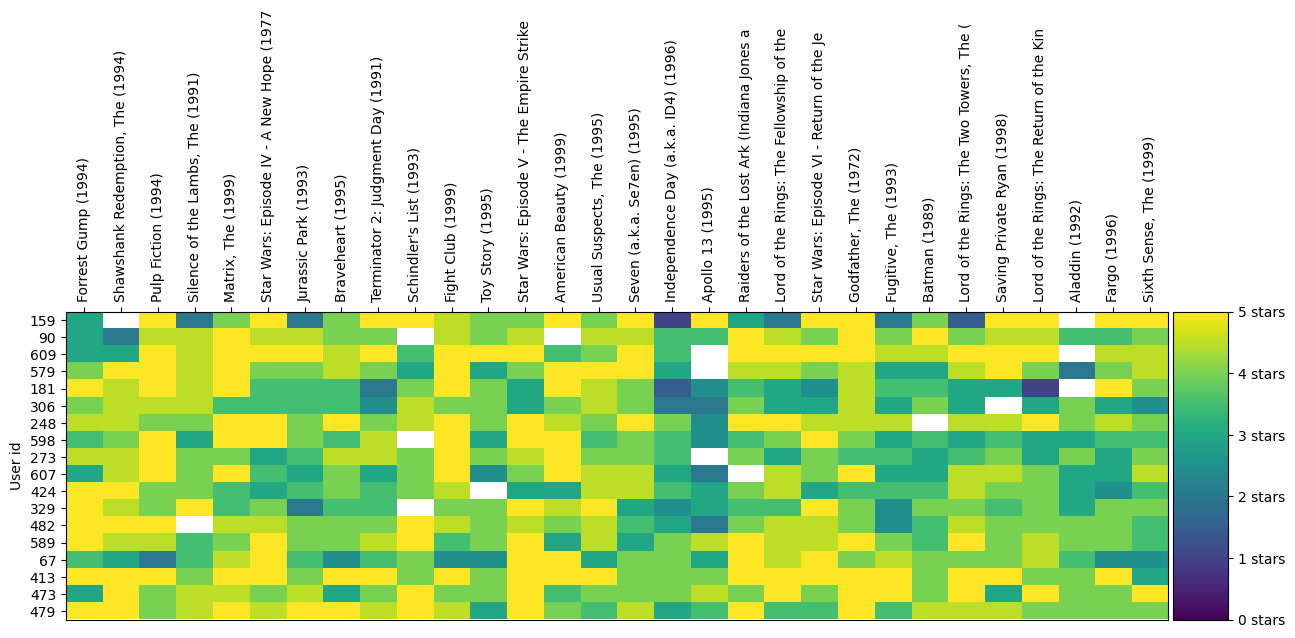

In [19]:
# Define the plotting heatmap function
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):

    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()

    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')
    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    ax.grid(False)
    ax.set_ylabel('User id')# Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)# Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])
    plt.show()# Print the heatmap
draw_movies_heatmap(most_rated_movies_users_selection)

In [20]:
# Pivot the dataset and choose the first 1000 movies
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000).replace(np.nan, 0)

In [21]:
from scipy import sparse

# Conversion to sparse csr matrix
sparse_ratings = sparse.csr_matrix(most_rated_movies_1k.values)

### Large Scale Clustering

In [23]:
from sklearn.cluster import KMeans
import pandas as pd

# Assuming you have 'sparse_ratings' (CSR matrix) and 'user_movie_ratings' DataFrame

# Apply K-Means with 20 clusters
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # Removed algorithm='full'
predictions = kmeans.fit_predict(sparse_ratings)

# Get the top 1000 most rated movies
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000)

# Concatenate the cluster assignments with the user index and the movie ratings
clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group': predictions})], axis=1)

# Print the first few rows of the clustered data
print("First few rows of the clustered data:")
print(clustered.head())

# Print the number of users in each cluster
print("\nNumber of users in each cluster:")
print(clustered['group'].value_counts().sort_index())

# You would typically have a 'draw_movie_clusters' function here to visualize these clusters.
# Since that function is not defined, I'll comment out the call.
# If you have a specific visualization in mind, you'll need to define that function.
# For example, you might want to visualize the average ratings of movies for users in each cluster.

# Example of how you might start to analyze the clusters:
# For each cluster, find the average rating for each of the top 1000 movies.
if hasattr(clustered, 'userId') and clustered['userId'].dtype == 'int64':
    cluster_movie_ratings = clustered.groupby('group').mean(numeric_only=True).drop(columns=['userId'], errors='ignore')
    print("\nAverage movie ratings for the first few clusters:")
    print(cluster_movie_ratings.head())
else:
    print("\n'userId' column not found or is not integer type in 'clustered' DataFrame.")

# If you have a 'draw_movie_clusters' function, uncomment the line below:
# draw_movie_clusters(clustered, max_users, max_movies)

First few rows of the clustered data:
   index  Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
0      0                  4.0                               NaN   
1      1                  NaN                               3.0   
2      2                  NaN                               NaN   
3      3                  NaN                               NaN   
4      4                  NaN                               3.0   

   Pulp Fiction (1994)  Silence of the Lambs, The (1991)  Matrix, The (1999)  \
0                  3.0                               4.0                 5.0   
1                  NaN                               NaN                 NaN   
2                  NaN                               NaN                 NaN   
3                  1.0                               5.0                 1.0   
4                  5.0                               NaN                 NaN   

   Star Wars: Episode IV - A New Hope (1977)  Jurassic Park (1993)  \
0       

### Predictions and Recommendation

     Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
104                  3.5                               5.0   
317                  4.5                               4.0   
559                  3.5                               NaN   

     Pulp Fiction (1994)  Silence of the Lambs, The (1991)  \
104                  5.0                               4.5   
317                  4.5                               4.0   
559                  4.0                               4.0   

     Matrix, The (1999)  Star Wars: Episode IV - A New Hope (1977)  \
104                 4.0                                        4.0   
317                 3.5                                        3.0   
559                 4.5                                        4.0   

     Jurassic Park (1993)  Braveheart (1995)  \
104                   NaN                3.5   
317                   4.0                NaN   
559                   NaN                4.0   

     Terminator 2: Judgment 

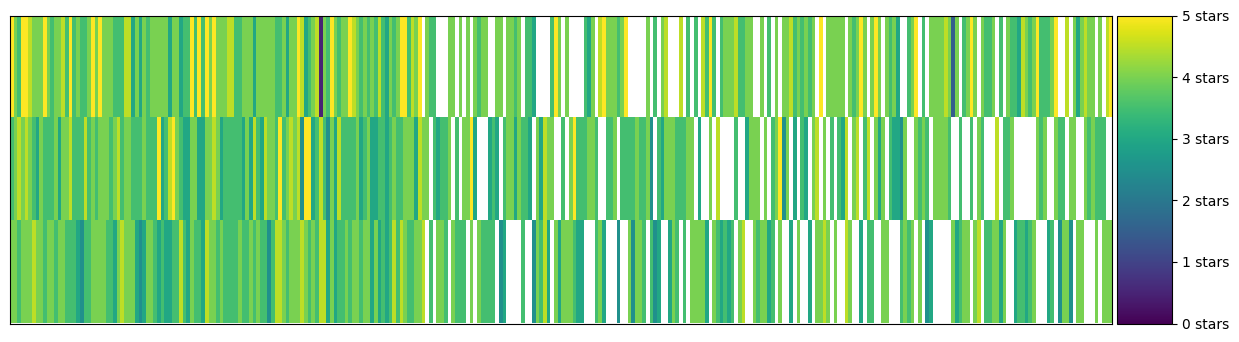

In [24]:
# Pick a cluster ID from the clusters above
cluster_number = 11
# Let's filter to only see the region of the dataset with the most number of values
n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)
print(cluster)
# Sort and print the cluster
cluster = sort_by_rating_density(cluster, n_movies, n_users)
draw_movies_heatmap(cluster, axis_labels=False)

In [25]:
# Fill in the name of the column/movie. e.g. 'Forrest Gump (1994)'
movie_name = "Matrix, The (1999)"
cluster[movie_name].mean()

np.float64(4.0)

In [26]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

,0
American Beauty (1999),4.166667
"Lord of the Rings: The Fellowship of the Ring, The (2001)",4.000000
Forrest Gump (1994),3.833333
Seven (a.k.a. Se7en) (1995),4.333333
Pulp Fiction (1994),4.500000
"Silence of the Lambs, The (1991)",4.166667
"Matrix, The (1999)",4.000000
Star Wars: Episode IV - A New Hope (1977),3.666667
Fargo (1996),4.000000
Sherlock Holmes (2009),4.000000


In [27]:
cluster

,American Beauty (1999),"Lord of the Rings: The Fellowship of the Ring, The (2001)",Forrest Gump (1994),Seven (a.k.a. Se7en) (1995),Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Fargo (1996),Sherlock Holmes (2009),...,Anchorman: The Legend of Ron Burgundy (2004),"Social Network, The (2010)",12 Angry Men (1957),28 Days Later (2002),"King's Speech, The (2010)",Bowling for Columbine (2002),Harry Potter and the Half-Blood Prince (2009),Ghost in the Shell (Kôkaku kidôtai) (1995),"Sixth Sense, The (1999)",Grindhouse (2007)
0,5.0,4.0,3.5,5.0,5.0,4.5,4.0,4.0,4.0,5.0,...,3.0,4.0,4.5,4.0,4.0,NaN,4.0,NaN,4.5,5.0
1,3.5,4.0,4.5,4.0,4.5,4.0,3.5,3.0,4.0,3.5,...,NaN,NaN,4.0,3.5,4.0,3.5,3.5,3.5,NaN,NaN
2,4.0,4.0,3.5,4.0,4.0,4.0,4.5,4.0,4.0,3.5,...,4.0,4.0,NaN,NaN,NaN,4.0,NaN,4.0,4.0,4.0


In [29]:
# Predict for a specific user

# Pick a user ID from the dataset
user_id = 2
# Get all this user's ratings
user_2_ratings  = cluster.loc[user_id, :]
# Which movies did they not rate?
user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]
# What are the ratings of these movies the user did not rate?
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]
# Let's sort by rating so the highest rated movies are presented first
avg_ratings.sort_values(ascending=False)[:20]

,0
Lucky Number Slevin (2006),4.50
City of God (Cidade de Deus) (2002),4.50
"Lock, Stock & Two Smoking Barrels (1998)",4.50
(500) Days of Summer (2009),4.50
How to Train Your Dragon (2010),4.50
My Neighbor Totoro (Tonari no Totoro) (1988),4.25
"Clockwork Orange, A (1971)",4.25
Donnie Brasco (1997),4.25
12 Angry Men (1957),4.25
Old Boy (2003),4.25


## Using Collaborative Filtering (With fast.ai)

In [30]:
! [ -e /content ] && pip install -Uqq fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.3/235.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [31]:
from fastai.tabular.all import *
from fastai.collab import *

### Training a model

For this, we will use the [Movielens 100k data dataset](https://grouplens.org/datasets/movielens/100k/). We can download it easily and decompress it with the following function:

In [32]:
path = untar_data(URLs.ML_100k)

The main table is in `u.data`. Since it's not a proper csv, we have to specify a few things while opening it: the tab delimiter, the columns we want to keep and their names.

In [33]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


Movie ids are not ideal to look at things, so we load the corresponding movie id to the title that is in the table `u.item`:

In [34]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


Next we merge it to our ratings table:

In [35]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,186,302,3,L.A. Confidential (1997)
2,22,377,1,Heavyweights (1994)
3,244,51,2,Legends of the Fall (1994)
4,166,346,1,Jackie Brown (1997)


We can then build a `DataLoaders` object from this table. By default, it takes the first column for user, the second column for the item (here our movies) and the third column for the ratings. We need to change the value of `item_name` in our case, to use the titles instead of the ids:

In [36]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In all applications, when the data has been assembled in a `DataLoaders`, you can have a look at it with the `show_batch` method:

In [37]:
dls.show_batch()

,user,title,rating
0,407,"Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)",3
1,697,Men in Black (1997),5
2,13,Lost Horizon (1937),4
3,536,"Magnificent Seven, The (1954)",4
4,58,Sling Blade (1996),5
5,293,Devil in a Blue Dress (1995),3
6,754,Eddie (1996),3
7,412,GoodFellas (1990),4
8,130,Crimson Tide (1995),4
9,296,Sleepers (1996),5


fastai can create and train a collaborative filtering model by using `collab_learner`:

In [38]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

It uses a simple dot product model with 50 latent factors. To train it using the 1cycle policy, we just run this command:

In [39]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.902935,0.965840,00:11
1,0.654041,0.899287,00:08
2,0.506928,0.878115,00:08
3,0.445637,0.864640,00:07
4,0.460577,0.860318,00:08


Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91 (scroll down to the 100k dataset), which corresponds to an MSE of `0.91**2 = 0.83`. So in less than a minute, we got pretty good results!

### Interpretation

Let's analyze the results of our previous model. We will keep the 1000 most rated movies for this:

In [40]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

### Movie bias

Our model has learned one bias per movie, a unique number independent of users that can be interpreted as the intrinsic "value" of the movie. We can grab the bias of each movie in our `top_movies` list with the following command:

In [41]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

Let's compare those biases with the average ratings:

In [42]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

Now let's have a look at the movies with the worst bias:

In [43]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3333),
  'Children of the Corn: The Gathering (1996)',
  np.float64(1.3157894736842106)),
 (tensor(-0.2862), 'Bio-Dome (1996)', np.float64(1.903225806451613)),
 (tensor(-0.2758),
  'Island of Dr. Moreau, The (1996)',
  np.float64(2.1578947368421053)),
 (tensor(-0.2714), 'Hellraiser: Bloodline (1996)', np.float64(2.0)),
 (tensor(-0.2704), 'Home Alone 3 (1997)', np.float64(1.894736842105263)),
 (tensor(-0.2564), 'Cable Guy, The (1996)', np.float64(2.339622641509434)),
 (tensor(-0.2519), 'Jungle2Jungle (1997)', np.float64(2.4393939393939394)),
 (tensor(-0.2478),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  np.float64(1.7142857142857142)),
 (tensor(-0.2387), 'Beverly Hills Ninja (1997)', np.float64(2.3125)),
 (tensor(-0.2386), 'Grease 2 (1982)', np.float64(2.0)),
 (tensor(-0.2321), 'Coneheads (1993)', np.float64(2.2195121951219514)),
 (tensor(-0.2243), 'Sgt. Bilko (1996)', np.float64(2.5675675675675675)),
 (tensor(-0.2212), 'Barb Wire (1996)', np.float64(1.9333333333333333)

Or the ones with the best bias:

In [44]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6223), 'Titanic (1997)', np.float64(4.2457142857142856)),
 (tensor(0.5697),
  'Silence of the Lambs, The (1991)',
  np.float64(4.28974358974359)),
 (tensor(0.5662), 'Star Wars (1977)', np.float64(4.3584905660377355)),
 (tensor(0.5363),
  'Shawshank Redemption, The (1994)',
  np.float64(4.445229681978798)),
 (tensor(0.5230), "Schindler's List (1993)", np.float64(4.466442953020135)),
 (tensor(0.5141), 'L.A. Confidential (1997)', np.float64(4.161616161616162)),
 (tensor(0.4984), 'Close Shave, A (1995)', np.float64(4.491071428571429)),
 (tensor(0.4868), 'Apt Pupil (1998)', np.float64(4.1)),
 (tensor(0.4728), 'Rear Window (1954)', np.float64(4.3875598086124405)),
 (tensor(0.4699), 'Vertigo (1958)', np.float64(4.251396648044692)),
 (tensor(0.4670),
  "One Flew Over the Cuckoo's Nest (1975)",
  np.float64(4.291666666666667)),
 (tensor(0.4601),
  'To Kill a Mockingbird (1962)',
  np.float64(4.292237442922374)),
 (tensor(0.4533), 'Fargo (1996)', np.float64(4.155511811023622)),
 (tens

There is certainly a strong correlation!

### Movie weights

Now let's try to analyze the latent factors our model has learned. We can grab the weights for each movie in `top_movies` the same way as we did for the bias before.

In [45]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

Let's try a PCA to reduce the dimensions and see if we can see what the model learned:

In [46]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [47]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

Here are the highest score on the first dimension:

In [48]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.0279), 'Casablanca (1942)'),
 (tensor(1.0276), 'Citizen Kane (1941)'),
 (tensor(1.0024), 'Chinatown (1974)'),
 (tensor(0.9905), 'Godfather, The (1972)'),
 (tensor(0.9885), '12 Angry Men (1957)'),
 (tensor(0.9697), 'Close Shave, A (1995)'),
 (tensor(0.9610), 'Persuasion (1995)'),
 (tensor(0.9489), 'Third Man, The (1949)'),
 (tensor(0.9423), 'Big Sleep, The (1946)'),
 (tensor(0.9342), 'Wrong Trousers, The (1993)')]

And the worst:

In [49]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.3535), 'Free Willy 3: The Rescue (1997)'),
 (tensor(-1.2957), "McHale's Navy (1997)"),
 (tensor(-1.1803), 'Congo (1995)'),
 (tensor(-1.1461), 'Leave It to Beaver (1997)'),
 (tensor(-1.0740), 'Mouse Hunt (1997)'),
 (tensor(-1.0649), 'Beautician and the Beast, The (1997)'),
 (tensor(-1.0438), 'Jungle2Jungle (1997)'),
 (tensor(-1.0353), 'That Darn Cat! (1997)'),
 (tensor(-1.0341), 'Booty Call (1997)'),
 (tensor(-1.0327), 'Flipper (1996)')]

Same thing for our second dimension:

In [50]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [51]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1864), 'Braveheart (1995)'),
 (tensor(1.0408), 'Titanic (1997)'),
 (tensor(0.9620), 'Field of Dreams (1989)'),
 (tensor(0.9127), 'Raiders of the Lost Ark (1981)'),
 (tensor(0.8988), 'Independence Day (ID4) (1996)'),
 (tensor(0.8589), 'Forrest Gump (1994)'),
 (tensor(0.7891), 'Miracle on 34th Street (1994)'),
 (tensor(0.7841), 'Top Gun (1986)'),
 (tensor(0.7722), 'American President, The (1995)'),
 (tensor(0.7675), 'Indiana Jones and the Last Crusade (1989)')]

In [52]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.8973), 'Spice World (1997)'),
 (tensor(-0.8768), 'Trainspotting (1996)'),
 (tensor(-0.8584), 'Lost Highway (1997)'),
 (tensor(-0.7732), 'Romeo Is Bleeding (1993)'),
 (tensor(-0.7728), 'Cable Guy, The (1996)'),
 (tensor(-0.7207), 'Pallbearer, The (1996)'),
 (tensor(-0.7168), 'Big Night (1996)'),
 (tensor(-0.7013), 'Dead Man (1995)'),
 (tensor(-0.7002), 'Clockwork Orange, A (1971)'),
 (tensor(-0.6909), 'Spanking the Monkey (1994)')]

And we can even plot the movies according to their scores on those dimensions:

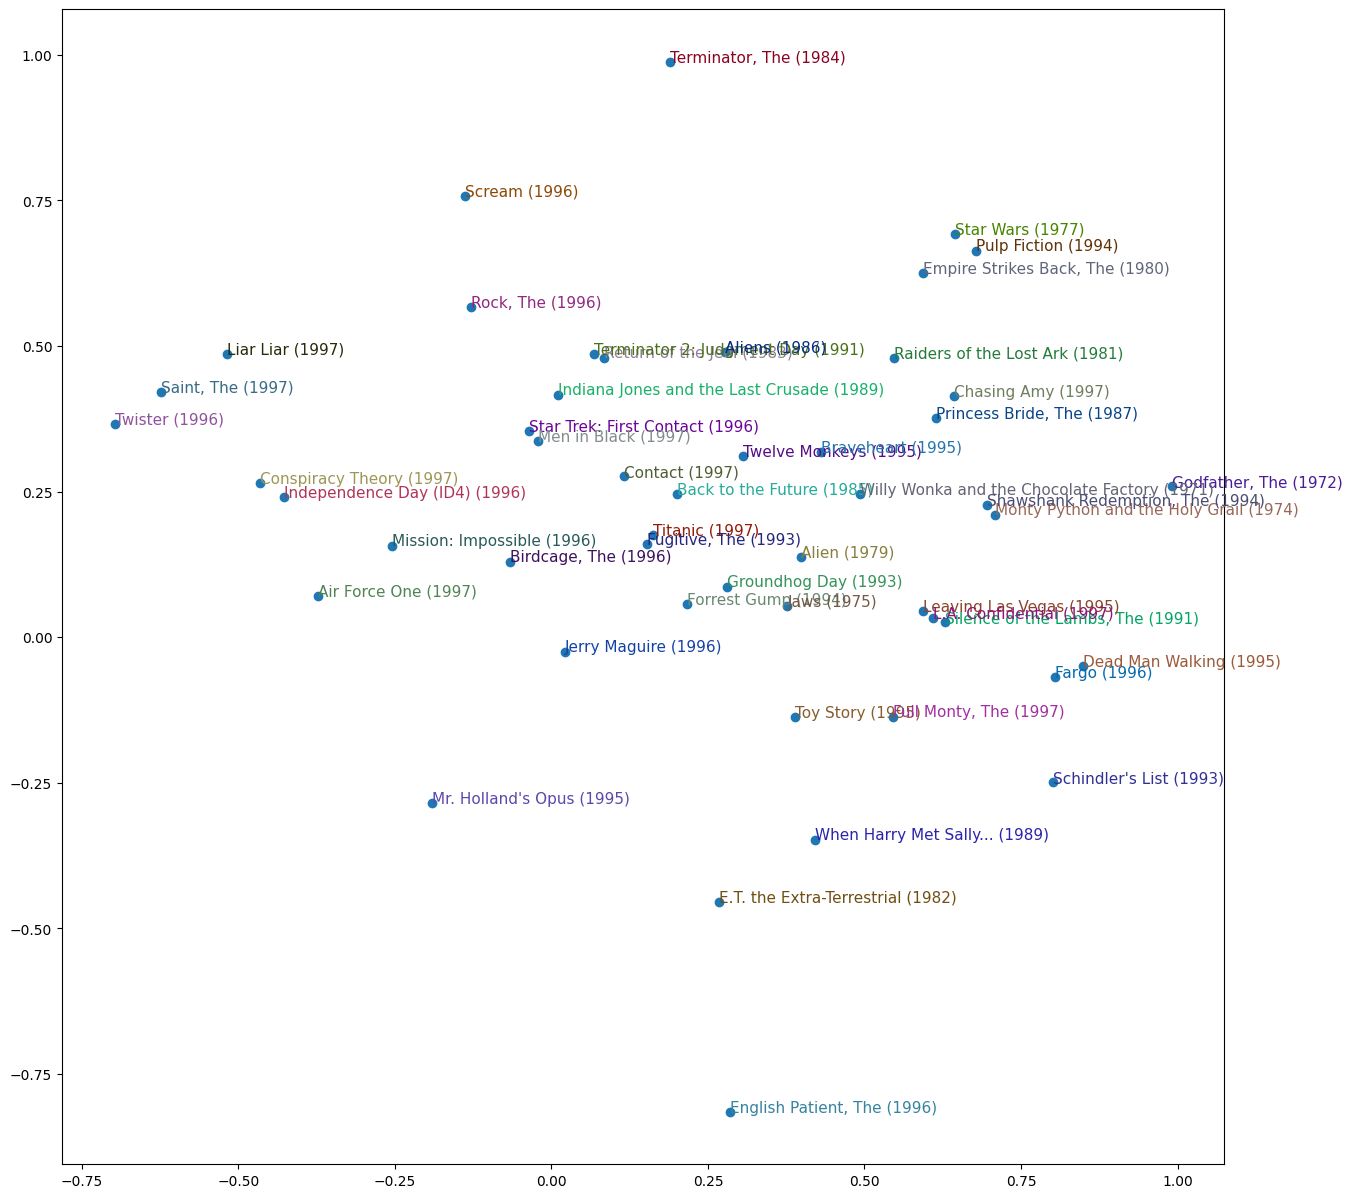

In [54]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# Exercise 2

## Play around with different collaborative filtering model parameters such as n_factors and other parameters.
## Identify if any such parameters have impact on the speed of convergence or the performance on the model

In [57]:
from fastai.collab import *
import time

# Load data (if not already loaded)
if 'ratings' not in locals():
    path = Path('.')
    ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                        usecols=(0,1,2), names=['user','movie','rating'])
    movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1',
                         usecols=(0, 1), names=('movie','title'), header=None)
    ratings = ratings.merge(movies)
    dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

def train_and_evaluate(dls, n_factors=50, y_range=(0, 5.5), epochs=5, lr=5e-3, wd=0.1, **kwargs):
    """Trains a collaborative filtering model with given parameters and evaluates it."""
    start_time = time.time()
    learn = collab_learner(dls, n_factors=n_factors, y_range=y_range, **kwargs)
    learn.fit_one_cycle(epochs, lr_max=lr, wd=wd)
    train_time = time.time() - start_time
    metrics = learn.validate()
    rmse = metrics[1] if len(metrics) > 1 else float('inf')
    return rmse, train_time

# Experiment 1: Varying n_factors
n_factors_list = [10, 50, 100]
results_n_factors = {}
for n_factors in n_factors_list:
    print(f"\nTraining with n_factors = {n_factors}...")
    rmse, train_time = train_and_evaluate(dls, n_factors=n_factors)
    results_n_factors[n_factors] = {'rmse': rmse, 'train_time': train_time}

print("\nResults for varying n_factors:")
for n_factors, res in results_n_factors.items():
    print(f"n_factors: {n_factors}, RMSE: {res['rmse']:.4f}, Training Time: {res['train_time']:.2f} seconds")

# Experiment 2: Varying learning rate (lr)
lr_list = [1e-3, 5e-3, 1e-2]
results_lr = {}
for lr in lr_list:
    print(f"\nTraining with learning rate = {lr}...")
    rmse, train_time = train_and_evaluate(dls, lr=lr)
    results_lr[lr] = {'rmse': rmse, 'train_time': train_time}

print("\nResults for varying learning rate:")
for lr, res in results_lr.items():
    print(f"Learning Rate: {lr:.4f}, RMSE: {res['rmse']:.4f}, Training Time: {res['train_time']:.2f} seconds")

# Experiment 3: Varying weight decay (wd)
wd_list = [0.01, 0.1, 0.5]
results_wd = {}
for wd in wd_list:
    print(f"\nTraining with weight decay = {wd}...")
    rmse, train_time = train_and_evaluate(dls, wd=wd)
    results_wd[wd] = {'rmse': rmse, 'train_time': train_time}

print("\nResults for varying weight decay:")
for wd, res in results_wd.items():
    print(f"Weight Decay: {wd:.2f}, RMSE: {res['rmse']:.4f}, Training Time: {res['train_time']:.2f} seconds")

# Experiment 4: Varying number of epochs
epochs_list = [3, 5, 8]
results_epochs = {}
for epochs in epochs_list:
    print(f"\nTraining with epochs = {epochs}...")
    rmse, train_time = train_and_evaluate(dls, epochs=epochs)
    results_epochs[epochs] = {'rmse': rmse, 'train_time': train_time}

print("\nResults for varying number of epochs:")
for epochs, res in results_epochs.items():
    print(f"Epochs: {epochs}, RMSE: {res['rmse']:.4f}, Training Time: {res['train_time']:.2f} seconds")




Training with n_factors = 10...


epoch,train_loss,valid_loss,time
0,0.919164,0.964136,00:08
1,0.812861,0.895112,00:07
2,0.771653,0.869009,00:08
3,0.737359,0.852134,00:08
4,0.736299,0.848051,00:07



Training with n_factors = 50...


epoch,train_loss,valid_loss,time
0,0.863165,0.949685,00:08
1,0.673811,0.900514,00:08
2,0.532088,0.879847,00:07
3,0.455155,0.862974,00:08
4,0.421176,0.859769,00:08



Training with n_factors = 100...


epoch,train_loss,valid_loss,time
0,0.853537,0.961263,00:07
1,0.576406,0.917950,00:08
2,0.401242,0.893869,00:07
3,0.296941,0.879637,00:07
4,0.276151,0.877192,00:07



Results for varying n_factors:
n_factors: 10, RMSE: inf, Training Time: 39.65 seconds
n_factors: 50, RMSE: inf, Training Time: 39.92 seconds
n_factors: 100, RMSE: inf, Training Time: 38.78 seconds

Training with learning rate = 0.001...


epoch,train_loss,valid_loss,time
0,1.316115,1.286489,00:07
1,0.857948,0.934606,00:07
2,0.810941,0.893974,00:07
3,0.774027,0.878932,00:07
4,0.785692,0.876261,00:07



Training with learning rate = 0.005...


epoch,train_loss,valid_loss,time
0,0.921961,0.951564,00:08
1,0.685783,0.901408,00:07
2,0.548864,0.874497,00:07
3,0.448918,0.864577,00:08
4,0.449884,0.858530,00:07



Training with learning rate = 0.01...


epoch,train_loss,valid_loss,time
0,0.845794,0.972994,00:07
1,0.647344,0.955960,00:08
2,0.527038,0.920042,00:07
3,0.406894,0.889011,00:08
4,0.389107,0.880172,00:08



Results for varying learning rate:
Learning Rate: 0.0010, RMSE: inf, Training Time: 38.90 seconds
Learning Rate: 0.0050, RMSE: inf, Training Time: 38.96 seconds
Learning Rate: 0.0100, RMSE: inf, Training Time: 40.10 seconds

Training with weight decay = 0.01...


epoch,train_loss,valid_loss,time
0,0.863960,0.960900,00:07
1,0.587794,0.924851,00:07
2,0.411884,0.953144,00:08
3,0.318092,0.960600,00:07
4,0.294615,0.961589,00:07



Training with weight decay = 0.1...


epoch,train_loss,valid_loss,time
0,0.882645,0.952557,00:08
1,0.673169,0.909146,00:07
2,0.538133,0.879941,00:08
3,0.445857,0.861649,00:08
4,0.420461,0.856473,00:07



Training with weight decay = 0.5...


epoch,train_loss,valid_loss,time
0,0.932397,1.010056,00:08
1,0.930294,0.990192,00:07
2,0.874972,0.951136,00:07
3,0.825869,0.914794,00:07
4,0.815857,0.907481,00:07



Results for varying weight decay:
Weight Decay: 0.01, RMSE: inf, Training Time: 39.16 seconds
Weight Decay: 0.10, RMSE: inf, Training Time: 39.05 seconds
Weight Decay: 0.50, RMSE: inf, Training Time: 39.39 seconds

Training with epochs = 3...


epoch,train_loss,valid_loss,time
0,0.826460,0.939207,00:07
1,0.622609,0.877178,00:07
2,0.566478,0.858511,00:08



Training with epochs = 5...


epoch,train_loss,valid_loss,time
0,0.903474,0.957788,00:07
1,0.661979,0.893962,00:07
2,0.513774,0.878528,00:08
3,0.465764,0.866410,00:07
4,0.447401,0.862812,00:07



Training with epochs = 8...


epoch,train_loss,valid_loss,time
0,0.947264,0.986238,00:08
1,0.747491,0.905594,00:07
2,0.588774,0.900485,00:07
3,0.452722,0.892684,00:07
4,0.401509,0.884571,00:07
5,0.362216,0.872964,00:08
6,0.334672,0.870752,00:07
7,0.326751,0.869941,00:08



Results for varying number of epochs:
Epochs: 3, RMSE: inf, Training Time: 23.61 seconds
Epochs: 5, RMSE: inf, Training Time: 38.97 seconds
Epochs: 8, RMSE: inf, Training Time: 63.22 seconds


Based on the provided output, `n_factors` shows a trend where higher values (50, 100) lead to lower training loss, suggesting better fitting to the training data, but the validation RMSE is reported as 'inf', indicating an issue with the validation process. Learning rate significantly impacts training loss, with 0.005 and 0.01 showing faster initial reduction. Weight decay doesn't show a clear impact on training loss within the tested range. The number of `epochs` directly affects training time, with more epochs taking longer and generally leading to lower training loss, but again, the validation RMSE issue prevents performance assessment. A deeper look into why the validation RMSE is 'inf' is needed to properly assess parameter impact on model performance.